# Auxiliary functions for MOPAC calculations

In this tutorial, we demonstrate some auxiliary functions that could be used with MOPAC calculations to get some properties relevant for NA-MD simulations, such as energies, orbitals, time-overlaps, etc.


## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#1)
2. [Reading a snapshot from the xyz trajectory file](#2)
3. [Creating input files for MOPAC calculations](#3)
4. [Running MOPAC calculations](#4)
5. [Reading molecular orbitals/energies and CI vectors](#5)
6. [Computing time-overlaps](#6)
7. [Reading molecular orbitals/energies and CI vectors. Using active space of MOs](#7)
8. [Possible sources of errors](#8)
9. [The remedy](#9)

   9.1. [Major flaw remedy - but low accuracy](#9.1)
   
   9.2. [Improving the accuracy](#9.2)
   
10. [The workflow](#10)

    10.1. [Standard approach - use all the orbitals](#10.1)
    
    10.2. [Using the reduced approach - use only a sub-space of orbitals](#10.2)
    
    10.3. [Let's compare the time-overlaps computed in the two ways](#10.3)


### A. Learning objectives

* To generate the input files for MOPAC calculations from the xyz trajectory file
* To extract the key infromation from the output file of MOPAC calculations (energies, MOs, CI vectors, etc.)
* To automate the calculations of the CI time-overlaps, adiabatic Hamiltonians, and adiabatic vibronic Hamiltonians using MOPAC


### B. Use cases

* INDO calculations with Libra 
* manually construct a Slater Determinant bais 
* processing the MOPAC calculations results
* computing CI wavefunction time-overlaps with MOPAC
* define Libra/MOPAC interface Hamiltonian
* computing single-particle (KS-DFT, HF, semiempirical) NACs
* computing many-body (TD-DFT, TD-DFTB, CI) NACs

### C. Functions

- `libra_py`
  - `workflows`
    - `nbra`
      - `mapping2`
        - [`ovlp_mat_arb`](#ovlp_mat_arb-1)
  - `packages`
    - `cp2k`
      - `methods`
        - [`read_trajectory_xyz_file`](#read_trajectory_xyz_file-1) | [`also here`](#read_trajectory_xyz_file-2)
    - `mopac`
      - `methods`
        - [`make_mopac_input`](#make_mopac_input-1)
        - [`run_mopac`](#run_mopac-1)
        - [`make_ref`](#make_ref-1)
        - [`make_alpha_excitation`](#make_alpha_excitation-1)
        - [`read_mopac_orbital_info`](#read_mopac_orbital_info-1)
        - [` mopac_compute_adi`](#mopac_compute_adi-1)
        

## 1. Importing needed libraries <a name="1"></a>
[Back to TOC](#toc)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from liblibra_core import *
import libra_py.packages.cp2k.methods as cp2k
import libra_py.packages.mopac.methods as mopac
import libra_py.workflows.nbra.mapping2 as mapping2
import libra_py.units as units

%matplotlib inline 

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 2. Reading  a snapshot from the xyz trajectory file<a name="2"></a>
[Back to TOC](#toc)

We read the first (zero-th) snapshot of the `1_ring-pos-1.xyz` trajectory file

The function determines the names of the N atoms in the system and saves the x, y, and z coordinates to MATRIX(3N,1) format and converts the coordinates from Angstrom to Bohr

We can print out the atomic labels - 6 carbons and 6 hydrogens - this is a benzene molecule.

The execution of this function also creates the corresponding coordinate xyz file, named "coord-0.xyz". The numerical index corresponds to the index of the snapshot we are reading in
<a name="read_trajectory_xyz_file-1"></a>

In [2]:
labels, q = cp2k.read_trajectory_xyz_file("1_ring-pos-1.xyz", 0)

print(labels)
q.show_matrix()

['C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
11.880518   
12.872152   
14.172945   
11.899982   
15.507942   
14.173134   
14.153481   
11.537250   
14.172945   
14.192598   
16.808829   
14.172756   
16.445907   
12.838326   
14.172945   
16.465372   
15.473927   
14.172945   
10.095483   
11.859259   
14.172945   
10.130254   
16.547291   
14.173134   
14.138174   
9.4848182   
14.172756   
14.207716   
18.861072   
14.172945   
18.215825   
11.798977   
14.173134   
18.250407   
16.487009   
14.172945   



Read more:

In [3]:
help(cp2k.read_trajectory_xyz_file)

Help on function read_trajectory_xyz_file in module libra_py.packages.cp2k.methods:

read_trajectory_xyz_file(file_name: str, step: int)
    This function reads the trajectory of a molecular dynamics .xyz file and
    extract the 'step' th step then writes it to coord-step.xyz file. This function
    is used in single point calculations for calculations of the NACs where one has
    previously obtained the trajectory via any molecular dynamics packages. 
    
    Args:
    
        file_name (string): The trajectory .xyz file name.
            step (integer): The desired time to extract its .xyz 
                            coordinates which starts from zero.
    
    Returns:
    
        (list, MATRIX(ndof, 1)): labels of all atoms, and their coordinates, ndof = 3 * natoms



## 3. Creating input files for MOPAC calculations<a name="3"></a>
[Back to TOC](#toc)

We are now ready to use this information to create an input file for MOPAC calculations using `make_mopac_input`
<a name="make_mopac_input-1"></a>

In [4]:
help(mopac.make_mopac_input)

Help on function make_mopac_input in module libra_py.packages.mopac.methods:

make_mopac_input(mopac_input_filename, mopac_run_params, labels, coords)
    This function creates an input file for MOPAC package using the 
    parameters passed in the `mopac_input_params` dictionary
    
    Args: 
        * mopac_input_filename ( string ): the name of the input file to create
    
        * mopac_run_params ( string ): the string containing the specification for the MOPAC run. 
        E.g. one can use: "INDO C.I.=(6,3) CHARGE=0 RELSCF=0.000001 ALLVEC  WRTCONF=0.00  WRTCI=2"
    
        * labels (list of stings): element symbols for atoms in the system (N items), e.g.
         ["C", "H", "H", "H", "H"] for methane
    
        * coords ( MATRIX(3N, 1) ): Cartesian coordinates of all atoms ordered in triples x, y, z [ units: Bohr ]
    
    Returns:
        None :  just creates the files



In particular, we are going to create an "input.mop" file in whihch we'll request CASSCF(6,3) calculations on the read benzene geometry. We also request to print the MOs and CI vectors:

In [5]:
mopac_input_filename = "input.mop"
mopac_run_params = "INDO C.I.=(6,3) CHARGE=0 RELSCF=0.000001 ALLVEC  WRTCONF=0.00  WRTCI=2"
mopac.make_mopac_input(mopac_input_filename, mopac_run_params, labels, q)

## 4. Running MOPAC calculations<a name="4"></a>
[Back to TOC](#toc)

To prepare the working folders, input files (from the xyz trajectory files) and to run the MOPAC calculations, we can use the `run_mopac` function:
<a name="run_mopac-1"></a>

In [6]:
help(mopac.run_mopac)

Help on function run_mopac in module libra_py.packages.mopac.methods:

run_mopac(coords, params_)
    This function executes the MOPAC quantum chemistry calculations 
    
    Args: 
        coords ( MATRIX(ndof, 1) ): coordinates of the particle [ units: Bohr ]
        params ( dictionary ): model parameters
    
            * **params_["labels"]** ( list of strings ): the labels of atomic symbolc - for all atoms,
                and in a order that is consistent with the coordinates (in triples) stored in `q`.
                The number of this labels is `natoms`, such that `ndof` = 3 * `natoms`. [ Required ]                
            * **params_["mopac_exe"]** ( string ):  the full path to `the mopac` executable [ defaut: "mopac" ]
            * **params_["mopac_run_params"]** ( string ): the control string to define the MOPAC job
                [default: "INDO C.I.=(6,3) CHARGE=0 RELSCF=0.000001 ALLVEC  WRTCONF=0.00  WRTCI=2"]
            * **params_["mopac_working_directory"]**

As you can see, this function takes quite a while inputs, although some of them are already familiar to use. Indeed, this is what the functions called by this function will need to know

Now, we are going to read 5 snapshots from the trajectory files and create the corresponding input files and execute the corresponding MOPAC outputs.

Parameters:

   * `labels` - those we had already created
   * `mopac_exe` = "/home/alexvakimov/SOFTWARE/mopac/_build/mopac" - this is where the exe is located at the time of preparation of this tutorial
   * `mopac_run_params` - we don't specify anything - use the default string
   * `mopac_working_directory` - we don't specify anything - use the default value of "mopac_wd". This is the folder that will be created upon the first run. If the folder already exists - the present one will be used.
   * `mopac_jobid` - we distinguis the inputs and outputs for all timesteps; this is needed in case we run many jobs in parallel or the calculations are fast so may interfere with reading-writing the files.
   * `mopac_output_prefix` - this is where some job-related output will be redirected; note that MOPAC will create the output files with the prefixes related to the input files

<a name="read_trajectory_xyz_file-2"></a>

In [7]:
params_ = { "labels": labels, "mopac_exe":"/home/alexvakimov/SOFTWARE/mopac/_build/mopac" }

for i in range(5):
    _, q = cp2k.read_trajectory_xyz_file("1_ring-pos-1.xyz", i)
    params_.update( {"mopac_jobid":F"job{i}"} )
    mopac.run_mopac(q, params_)

As a result, this step should create the folder with the following content:

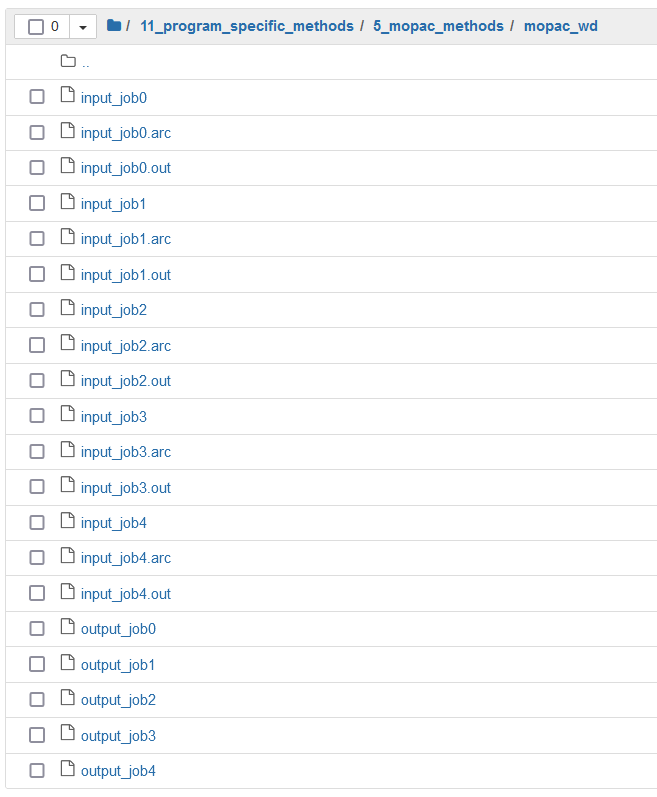

## 5. Reading molecular orbitals/energies and CI vectors<a name="4"></a>
[Back to TOC](#toc)

Now we are ready to parse the output files generated. This is done using `read_mopac_orbital_info` function:
<a name="read_mopac_orbital_info-1"></a>

In [8]:
help(mopac.read_mopac_orbital_info)

Help on function read_mopac_orbital_info in module libra_py.packages.mopac.methods:

read_mopac_orbital_info(params_)
    This function reads the MOs, configurations, and CI from the output files
    
    Args:
    
        params_ ( dict ): the dictionary containing key parameters
    
            * **params_["filename"]** ( string ) : the name of the file to read
            * **params_["active_space"]** (list of ints): the orbital numbers to be includes, the indexing starts with 1, not 0 [default: None]
        
    Returns: 
        (Es, MOs, E_CI, CI, configs): 
     
            * Es - MATRIX(nact, nact): the matrix of the MO energies for active MOs
            * MOs - MATRIX(nao, nact): the matrix of MO-LCAO coefficients for active MOs
            * E_CI - MATRIX(nci, nci): the matrix of CI energies
            * CI - MATRIX(nconf, nci): the matrix of CI coefficients in the basis of spin-adapted configurations
            * sd_basis - (list of lists of `nact` ints): representati

In this example code, we read the MOs, CI coeffs and configurations from the two consecutive steps since this is what we'll need for next step - calculation of time-overlaps

In [9]:
params = {}
params["filename"] = "mopac_wd/input_job0.out"
E0, MO0, E_CI0, CI0, configs0, configs_raw0 = mopac.read_mopac_orbital_info(params)

params["filename"] = "mopac_wd/input_job1.out"
E1, MO1, E_CI1, CI1, configs1, configs_raw1 = mopac.read_mopac_orbital_info(params)

We can now print different properties:

MO energies:

In [10]:
E0.show_matrix()

MO-LCAO coefficients

In [11]:
MO0.show_matrix()

 the default value 
-43.590190  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
0.0000000   -32.933370  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
0.0000000   0.0000000   -32.932470  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000

0.36460000  0.40958000  0.24514000  -0.15136000  0.31725000  0.069530000  -0.20457000  0.00054000000  0.052000000  0.076630000  -4.0000000e-05  0.00012000000  -0.0018100000  -2.0000000e-05  -2.0000000e-05  2.0000000e-05  -0.0000000  -0.34542000  -0.0023700000  -0.22088000  0.38316000  -0.16997000  -0.18669000  0.21209000  -0.074240000  0.11826000  0.012490000  0.12977000  0.015980000  -0.0000000  
0.13449000  -0.060970000  0.091170000  0.20561000  -0.031610000  -0.27829000  0.18640000  -0.20207000  0.13777000  0.35461000  -1.0000000e-05  0.19499000  -0.26380000  -1.0000000e-05  -1.0000000e-05  -0.0000000  1.0000000e-05  -0.046670000  -0.00033000000  -0.092780000  -0.072580000  0.17470000  0.068540000  -0.24348000  -0.29819000  0.39301000  0.11898000  0.27558000  -0.19143000  -0.20143000  
0.076340000  0.096460000  -0.16721000  -0.24480000  -0.19040000  -0.15798000  0.10708000  0.35472000  0.24231000  0.089950000  -7.0000000e-05  -0.30605000  -0.17422000  -4.0000000e-05  -1.0000000e-05 

Energies of CI states:

In [12]:
E_CI0.show_matrix()

0.0000000   0.0000000   
0.0000000   0.17352174  



CI coefficients giving the amplitudes of the corresponding spin-adapted configurations corresoinding to the determined excited Slater determinants (configurations):

In [13]:
CI0.show_matrix()

1.0000000   0.0000000   
0.0000000   -0.70444631  
0.0000000   -0.70440802  
0.0000000   -0.061518950  
0.0000000   0.061482990  



In this example, we have only 5 configurations and 5 electronic states, with the first state being the ground state.

Finally, we can print the basis of configurations. In this example, we have 30 electrons in total. The configurations are hence the lists of 30 numbers showing which spin-orbitals are occupied:

In [14]:
for config in configs0:
    print(config)

[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 17, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 16, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 16, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 17, -14, 15, -15]


As you can see, there are 5 configurations. The very first one is doubly-occupied up the MO level 15 - this is the ground state.

We can also print the "raw" configurations. By default, they should be the same as the "reduced ones above"

In [15]:
for config in configs_raw0:
    print(config)

[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 17, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 16, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 16, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 17, -14, 15, -15]


The ground-state configuration for 30 electrons can be generated using `make_ref` function, like this:
<a name="make_ref-1"></a>

In [16]:
GS = mopac.make_ref(30)

print(GS)

[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15]


In [17]:
help(mopac.make_ref)

Help on function make_ref in module libra_py.packages.mopac.methods:

make_ref(nelec, active_space=None)
    Makes the reference determinant based on the number of electrons
    
    Args: 
        nelec (int) : the total number of electrons in the system
        active_space (list of ints): the indices of allowed orbitals, starting from 1 [default: None]
    
    Returns:
        list of ints: representation of the reference (ground-state) determinant
    
        E.g. [1, -1, 2, -2] is the determinant of 4 electrons with 2 lowest orbitals doubly-filled 
        Here, the indexing starts with 1, and negative values correspond to the beta-spin electron
        while positive values - to the alpha-spin electron.
    
        If the active_space is [2], then the above reference determinant will become just [2, -2]



Other configurations are produced by the excitation of the ground state configuration using `make_alpha_excitation` function. For instance, the first excited configuration for the system is obtained by the 15->17 excitation:
<a name="make_alpha_excitation-1"></a>

In [18]:
S1 = mopac.make_alpha_excitation(GS, [15, 17])
print(S1)

[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 17, -15]


In [19]:
help(mopac.make_alpha_excitation)

Help on function make_alpha_excitation in module libra_py.packages.mopac.methods:

make_alpha_excitation(ref_determinant, config)
    This function creates an excitation of the alpha electron in the reference determinant
    exciting the electron from and to orbitals determined by the `config` argument
    
    Args: 
    
        ref_determinant (list of ints): representation of the reference determinants
         
        config (list of 2 ints): [src, targt]  - source and target orbitals for single excitation, the 
            indexing starts from 1, not from 0. 
    
    Returns: 
        list of ints: the representation of the excited configuration
    
    Example: 
        make_alpha_excitation([1, -1, 2, -2], [2, 3])  corresponds to 2->3 excitation and should return
      
        [1, -1, 3, -2]



## 6.Computing time-overlaps<a name="6"></a>
[Back to TOC](#toc)

Finally, we can use the information read from the two timesteps to compute some properties.

First - the number of MOs:

In [20]:
nmo = MO0.num_of_cols
print(nmo)

30


Second - the time-overlap in the MO basis. 

Since we are using INDO approximation, the time-overlaps of the AOs are assumed to be the identity matrix:

In [21]:
mo_st = MO0.T() * MO1  # time-overlap in MO basis
mo_st.show_matrix()

0.99997008  0.00087091820  0.0063494704  -0.00022272090  -0.0013797748  -0.00093333490  8.7622900e-05  -0.00057628510  0.0014667674  0.0023099110  0.00010774070  0.00083311740  -2.0852300e-05  -0.00054955280  3.8860300e-05  -3.4172700e-05  0.00015733960  -0.00024296760  0.00025064940  -0.00061101410  -0.00063657360  0.00056979080  -0.00055363110  -0.0014577138  -0.00012273160  8.7875000e-05  0.00017418840  -0.00018235430  0.00043386250  0.00021338900  
-0.0027891757  0.95150332  0.30749004  0.0076988755  -0.00036082810  -0.0033817290  -0.0019752089  -0.00074649870  -0.00014163450  -0.0011230614  5.5192400e-05  -0.0019098478  0.00091096000  -0.00030596460  -0.00018834740  -0.00014893220  -0.00026857790  0.00017091440  -7.3144100e-05  0.00065416700  0.00045795260  0.00037271630  8.6838800e-05  0.00071310160  -0.0014931570  0.00029942400  -0.00099101360  -6.1989000e-05  5.7270800e-05  0.00017278860  
0.0058048296  0.30746321  -0.95145206  0.0062824713  0.0048323747  0.0094393006  0.002014

Next, using the definitions of the SD configurations and the computed MO time-overlaps, we can now compute the time-overlaps of the SD functions. This is based on the function `ovlp_mat_arb` which uses the Lowdin formula for computing overlaps of the determinants.
<a name="ovlp_mat_arb-1"></a>

In [22]:
help(mapping2.ovlp_mat_arb)

Help on function ovlp_mat_arb in module libra_py.workflows.nbra.mapping2:

ovlp_mat_arb(SD1, SD2, S, reduce_det=False)
    Compute a matrix of overlaps in the SD basis 
    
    Args:
        SD1 ( list of lists of N ints ): a list of N SD determinants, such that:
            SD1[iSD] is a list of integers defining which orbitals are 
            occupied in SD with index ```iSD``` and how 
            SeeAlso: ```inp``` in the ```sd2indx(inp)``` function
    
        SD2 ( list of lists of M ints ): a list of M SD determinants, such that:
            SD2[iSD] is a list of integers defining which orbitals are 
            occupied in SD with index ```iSD``` and how 
            SeeAlso: ```inp``` in the ```sd2indx(inp)``` function
    
        S ( CMATRIX(K,K) ): is the matrix in the full space of 1-el orbitals. Note - the mapped indices should not 
            be larger than K-1
    
        reduce_det ( Boolean ): If True, use the minimal subset of orbitals needed to describe 
      

In [23]:
print("Time-overlap in the SD basis")
time_ovlp_sd = mapping2.ovlp_mat_arb(configs0, configs1, mo_st, False)
time_ovlp_sd.show_matrix()

Time-overlap in the SD basis
(0.99988285,0.0000000)  (0.0016620390,-0.0000000)  (-0.0014766285,0.0000000)  (0.00019866069,-0.0000000)  (-0.00028031999,0.0000000)  (-0.0024091481,0.0000000)  (0.00066303670,-0.0000000)  
(-0.0013352761,0.0000000)  (0.58250700,0.0000000)  (-0.41307486,0.0000000)  (-0.44657003,0.0000000)  (0.53882115,0.0000000)  (0.00019488990,0.0000000)  (-0.00025090479,0.0000000)  
(-0.0017747066,0.0000000)  (0.41308005,0.0000000)  (-0.58251696,0.0000000)  (0.53883965,0.0000000)  (-0.44656793,0.0000000)  (-0.0012051072,0.0000000)  (-0.00092830853,0.0000000)  
(-6.2559270e-05,0.0000000)  (-0.44657145,0.0000000)  (-0.53883378,0.0000000)  (-0.58252340,0.0000000)  (-0.41307828,0.0000000)  (0.00025017616,0.0000000)  (0.00019163184,0.0000000)  
(0.00033365834,-0.0000000)  (-0.53882635,0.0000000)  (-0.44656734,0.0000000)  (0.41308160,0.0000000)  (0.58250533,0.0000000)  (-0.00092793234,0.0000000)  (0.0012095751,0.0000000)  



Finally, we transform this the time-overlap to the time-overlap of the CI states using the correponding CI vectors:

In [24]:
print("Time-overlap in the CI basis")
time_ovlp_ci = CI0.T() * time_ovlp_sd.real() * CI1
time_ovlp_ci.show_matrix()

Time-overlap in the CI basis
0.99988285  0.0022192134  
0.0022151108  -0.99985445  



## 7. Reading molecular orbitals/energies and CI vectors. Using active space of MOs<a name="7"></a>
[Back to TOC](#toc)

The above procedure may be time- and memory-consuming, especially for large systems. This is not only about reading the files, but rather about what comes up next - computing the MO time-overlaps, and even much so - computing the SD (or configurations) time-overlaps. 

To reduce the costs, we wish to use only a subset of MOs (presumable well-bracketing the MOs that are actively involved in the excitations). So, we introduce the following keyword - `active_space`. In the present convention, the active space is a list of the orbitals (starting from 1) that are to be included. 

In the present example, we have seen that the excitation happen from HOMO-1 (14) into LUMO+1 (17), and anything in between, so we can define our active space as `[14, 15, 16, 17]`. Let's repeat the above calculatios using this active space

In [25]:
params = { "active_space": [14, 15,16, 17] }
params["filename"] = "mopac_wd/input_job0.out"
act_E0, act_MO0, act_E_CI0, act_CI0, act_configs0, act_configs_raw0 = mopac.read_mopac_orbital_info(params)

params["filename"] = "mopac_wd/input_job1.out"
act_E1, act_MO1, act_E_CI1, act_CI1, act_configs1, act_configs_raw1 = mopac.read_mopac_orbital_info(params)

Let's print out the corresponding properties:

In [26]:
act_E0.show_matrix()

-8.9747600  0.0000000   0.0000000   0.0000000   
0.0000000   -8.9741400  0.0000000   0.0000000   
0.0000000   0.0000000   0.85114000  0.0000000   
0.0000000   0.0000000   0.0000000   0.85165000  



and the corresponding slices of the bigger matrices we read in before:

In [27]:
e0 = MATRIX(4,4)
pop_submatrix(E0, e0, Py2Cpp_int([13,14,15,16]))
e0.show_matrix()

-8.9747600  0.0000000   0.0000000   0.0000000   
0.0000000   -8.9741400  0.0000000   0.0000000   
0.0000000   0.0000000   0.85114000  0.0000000   
0.0000000   0.0000000   0.0000000   0.85165000  



In [28]:
act_MO0.show_matrix()

-2.0000000e-05  -2.0000000e-05  2.0000000e-05  -0.0000000  
-1.0000000e-05  -1.0000000e-05  -0.0000000  1.0000000e-05  
-4.0000000e-05  -1.0000000e-05  3.0000000e-05  -1.0000000e-05  
0.53073000  0.22737000  -0.18036000  0.54849000  
6.0000000e-05  -4.0000000e-05  -2.0000000e-05  -7.0000000e-05  
8.0000000e-05  -4.0000000e-05  -0.0000000  -4.0000000e-05  
1.0000000e-05  0.0000000   2.0000000e-05  -1.0000000e-05  
0.46231000  -0.34589000  -0.38478000  -0.43047000  
-0.0000000  3.0000000e-05  3.0000000e-05  -1.0000000e-05  
0.0000000   1.0000000e-05  -1.0000000e-05  -1.0000000e-05  
0.0000000   -3.0000000e-05  -4.0000000e-05  1.0000000e-05  
0.068470000  0.57330000  0.56517000  -0.11807000  
2.0000000e-05  9.0000000e-05  -0.00010000000  5.0000000e-05  
-3.0000000e-05  -4.0000000e-05  1.0000000e-05  -3.0000000e-05  
-1.0000000e-05  -3.0000000e-05  -0.0000000  -1.0000000e-05  
-0.068400000  -0.57328000  0.56516000  -0.11800000  
2.0000000e-05  -2.0000000e-05  1.0000000e-05  2.0000000e-05  

In [29]:
mo0 = MATRIX(30,4)
pop_submatrix(MO0, mo0, Py2Cpp_int( list(range(30)) ), Py2Cpp_int([13,14,15,16]) )
mo0.show_matrix()

-2.0000000e-05  -2.0000000e-05  2.0000000e-05  -0.0000000  
-1.0000000e-05  -1.0000000e-05  -0.0000000  1.0000000e-05  
-4.0000000e-05  -1.0000000e-05  3.0000000e-05  -1.0000000e-05  
0.53073000  0.22737000  -0.18036000  0.54849000  
6.0000000e-05  -4.0000000e-05  -2.0000000e-05  -7.0000000e-05  
8.0000000e-05  -4.0000000e-05  -0.0000000  -4.0000000e-05  
1.0000000e-05  0.0000000   2.0000000e-05  -1.0000000e-05  
0.46231000  -0.34589000  -0.38478000  -0.43047000  
-0.0000000  3.0000000e-05  3.0000000e-05  -1.0000000e-05  
0.0000000   1.0000000e-05  -1.0000000e-05  -1.0000000e-05  
0.0000000   -3.0000000e-05  -4.0000000e-05  1.0000000e-05  
0.068470000  0.57330000  0.56517000  -0.11807000  
2.0000000e-05  9.0000000e-05  -0.00010000000  5.0000000e-05  
-3.0000000e-05  -4.0000000e-05  1.0000000e-05  -3.0000000e-05  
-1.0000000e-05  -3.0000000e-05  -0.0000000  -1.0000000e-05  
-0.068400000  -0.57328000  0.56516000  -0.11800000  
2.0000000e-05  -2.0000000e-05  1.0000000e-05  2.0000000e-05  

The reduced configurations:

In [30]:
for config in act_configs0:
    print(config)

[1, -1, 2, -2]
[1, -1, 4, -2]
[3, -1, 2, -2]
[1, -1, 3, -2]
[4, -1, 2, -2]


And the "raw" configurations:

In [31]:
for config in act_configs_raw0:
    print(config)

[14, -14, 15, -15]
[14, -14, 17, -15]
[16, -14, 15, -15]
[14, -14, 16, -15]
[17, -14, 15, -15]


These transitions correspond to the following mapping:

          original    mapped
           space       space

              14   ->    1
              15   ->    2
              16   ->    3
              17   ->    4


## 8. Possible sources of errors<a name="8"></a>
[Back to TOC](#toc)

Now, let's compute the overlaps:

In [32]:
act_mo_st = act_MO0.T() * act_MO1  # time-overlap in MO basis
act_mo_st.show_matrix()

0.73408108  -0.67903038  0.0012195612  0.0013316169  
0.67903500  0.73408530  0.00085347740  -0.0010293683  
0.0013480976  -0.0011584415  -0.79360966  -0.60839576  
0.00066166120  0.0012106175  -0.60839273  0.79359549  



And the corresponding data from the prior calculations (this should be exactly the same):

In [33]:
mo_st0 = MATRIX(4,4)
pop_submatrix(mo_st, mo_st0, Py2Cpp_int([13,14,15,16]))
mo_st0.show_matrix()

0.73408108  -0.67903038  0.0012195612  0.0013316169  
0.67903500  0.73408530  0.00085347740  -0.0010293683  
0.0013480976  -0.0011584415  -0.79360966  -0.60839576  
0.00066166120  0.0012106175  -0.60839273  0.79359549  



Next, we compute the overlap of the configurations, but using the reduced functions - this is the approximation:

In [34]:
print("Time-overlap in the reduced SD/configuration basis")
act_time_ovlp_sd = mapping2.ovlp_mat_arb(act_configs0, act_configs1, act_mo_st, False).real()
act_time_ovlp_sd.show_matrix()

Time-overlap in the reduced SD/configuration basis
0.99992705  0.0016597937  -0.0014747452  0.00020159578  -0.00027853788  0.99992705  0.99992705  
-0.0013379307  0.58254130  -0.41310061  -0.44659411  0.53885741  -0.0013379307  -0.0013379307  
-0.0017761762  0.41310556  -0.58255495  0.53887023  -0.44659929  -0.0017761762  -0.0017761762  
-6.5006876e-05  -0.44659732  -0.53886683  -0.58255423  -0.41310568  -6.5006876e-05  -6.5006876e-05  
0.00033632363  -0.53886014  -0.44659690  0.41310546  0.58254678  0.00033632363  0.00033632363  



As a reminder, the previous result was:

In [35]:
time_ovlp_sd.real().show_matrix()

0.99988285  0.0016620390  -0.0014766285  0.00019866069  -0.00028031999  -0.0024091481  0.00066303670  
-0.0013352761  0.58250700  -0.41307486  -0.44657003  0.53882115  0.00019488990  -0.00025090479  
-0.0017747066  0.41308005  -0.58251696  0.53883965  -0.44656793  -0.0012051072  -0.00092830853  
-6.2559270e-05  -0.44657145  -0.53883378  -0.58252340  -0.41307828  0.00025017616  0.00019163184  
0.00033365834  -0.53882635  -0.44656734  0.41308160  0.58250533  -0.00092793234  0.0012095751  



As we can see, the results are quite close to each other. To find the source of the difference, let's look at the configurations at the second time-step:

In [36]:
for config in configs1:
    print(config)

for config in act_configs1:
    print(config)

for config in act_configs_raw1:
    print(config)

[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 17, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 16, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 16, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 17, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 16, -13, 14, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 17, -13, 14, -14, 15, -15]
[1, -1, 2, -2]
[1, -1, 4, -2]
[3, -1, 2, -2]
[1, -1, 3, -2]
[4, -1, 2, -2]
[1, -1, 2, -2]
[1, -1, 2, -2]
[14, -14, 15, -15]
[14, -14, 17, -15]
[16, -14, 15, -15]
[14, -14, 16

As we can see, all the full-space configurations are distinct, sicne they also involve excitations from HOMO-2. However, the reduced approach does not differentiate such configuations, since HOMO-2 is excluded from the active space. As a result, the reduced configurations become nominally the ground state configuration, which leads to incorrect. 

## 9. The remedy<a name="9"></a>
[Back to TOC](#toc)

### 9.1. Major flaw remedy - but low accuracy<a name="9.1"></a>
[Back to TOC](#toc)

The remedy for this situation is to extend the active space of MOs, to also include the HOMO-2 (13):

In [37]:
params = { "active_space": [13, 14, 15,16, 17] }

params["filename"] = "mopac_wd/input_job0.out"
fix_E0, fix_MO0, fix_E_CI0, fix_CI0, fix_configs0, fix_configs_raw0 = mopac.read_mopac_orbital_info(params)
print("n_mos = ", fix_MO0.num_of_cols)

params["filename"] = "mopac_wd/input_job1.out"
fix_E1, fix_MO1, fix_E_CI1, fix_CI1, fix_configs1, fix_configs_raw1 = mopac.read_mopac_orbital_info(params)
print("n_mos = ", fix_MO1.num_of_cols)

n_mos =  5
n_mos =  5


In [38]:
fix_mo_st = fix_MO0.T() * fix_MO1  # time-overlap in MO basis
fix_mo_st.show_matrix()

0.77143809  -0.0017996281  0.0010681030  0.00092088740  -0.0018514695  
0.0015281070  0.73408108  -0.67903038  0.0012195612  0.0013316169  
-0.00031495010  0.67903500  0.73408530  0.00085347740  -0.0010293683  
0.0015167817  0.0013480976  -0.0011584415  -0.79360966  -0.60839576  
0.0019957425  0.00066166120  0.0012106175  -0.60839273  0.79359549  



Again, the corresponding reference from the full set of MOs:

In [39]:
mo_st0 = MATRIX(5,5)
pop_submatrix(mo_st, mo_st0, Py2Cpp_int([12, 13,14,15,16]))
mo_st0.show_matrix()

0.77143809  -0.0017996281  0.0010681030  0.00092088740  -0.0018514695  
0.0015281070  0.73408108  -0.67903038  0.0012195612  0.0013316169  
-0.00031495010  0.67903500  0.73408530  0.00085347740  -0.0010293683  
0.0015167817  0.0013480976  -0.0011584415  -0.79360966  -0.60839576  
0.0019957425  0.00066166120  0.0012106175  -0.60839273  0.79359549  



In [40]:
#========== Time-step 0 ================
for config in configs0:
    print(config)

for config in fix_configs0:
    print(config)

for config in fix_configs_raw0:
    print(config)
#========== Time-step 1 ================
for config in configs1:
    print(config)

for config in fix_configs1:
    print(config)

for config in fix_configs_raw1:
    print(config)

[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 17, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 16, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 16, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 17, -14, 15, -15]
[1, -1, 2, -2, 3, -3]
[1, -1, 2, -2, 5, -3]
[1, -1, 4, -2, 3, -3]
[1, -1, 2, -2, 4, -3]
[1, -1, 5, -2, 3, -3]
[13, -13, 14, -14, 15, -15]
[13, -13, 14, -14, 17, -15]
[13, -13, 16, -14, 15, -15]
[13, -13, 14, -14, 16, -15]
[13, -13, 17, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6,

In [41]:
print("Time-overlap in the reduced (but conrrectly !) SD/configuration basis")
fix_time_ovlp_sd = mapping2.ovlp_mat_arb(fix_configs0, fix_configs1, fix_mo_st, False).real()
fix_time_ovlp_sd.show_matrix()

Time-overlap in the reduced (but conrrectly !) SD/configuration basis
0.59507792  0.00098958865  -0.00087700539  0.00011906978  -0.00016705895  -0.00071257206  0.0014264411  
-0.00079690560  0.34668519  -0.24584576  -0.26577899  0.32068723  -0.00020457604  0.00026618704  
-0.0010594305  0.24584524  -0.34669053  0.32069232  -0.26577831  -0.0012515208  -0.00096294396  
-3.9198473e-05  -0.26577827  -0.32069164  -0.34669159  -0.24584635  -0.00026805426  -0.00020562377  
0.00019700143  -0.32068752  -0.26577951  0.24584762  0.34668697  -0.00096064258  0.0012532434  



Once again, the reference matrix is:

In [42]:
time_ovlp_sd.real().show_matrix()

0.99988285  0.0016620390  -0.0014766285  0.00019866069  -0.00028031999  -0.0024091481  0.00066303670  
-0.0013352761  0.58250700  -0.41307486  -0.44657003  0.53882115  0.00019488990  -0.00025090479  
-0.0017747066  0.41308005  -0.58251696  0.53883965  -0.44656793  -0.0012051072  -0.00092830853  
-6.2559270e-05  -0.44657145  -0.53883378  -0.58252340  -0.41307828  0.00025017616  0.00019163184  
0.00033365834  -0.53882635  -0.44656734  0.41308160  0.58250533  -0.00092793234  0.0012095751  



### 9.2. Improving the accuracy<a name="9.2"></a>
[Back to TOC](#toc)

To further improve the accuracy, we can simply add a "buffer" layer of orbitals around the active space of orbitals involved in the excitations. Let's see what happens if we add also HOMO-3 (12) and LUMO+2 (18).

We repeat exactly the same major steps and print only the final results:

In [43]:
params = { "active_space": [12, 13, 14, 15, 16, 17, 18] }

params["filename"] = "mopac_wd/input_job0.out"
fix_E0, fix_MO0, fix_E_CI0, fix_CI0, fix_configs0, fix_configs_raw0 = mopac.read_mopac_orbital_info(params)
print("n_mos = ", fix_MO0.num_of_cols)

params["filename"] = "mopac_wd/input_job1.out"
fix_E1, fix_MO1, fix_E_CI1, fix_CI1, fix_configs1, fix_configs_raw1 = mopac.read_mopac_orbital_info(params)
print("n_mos = ", fix_MO1.num_of_cols)

fix_mo_st = fix_MO0.T() * fix_MO1

print("Time-overlap in the reduced extended SD/configuration basis")
fix_time_ovlp_sd = mapping2.ovlp_mat_arb(fix_configs0, fix_configs1, fix_mo_st, False).real()
fix_time_ovlp_sd.show_matrix()

print("The reference is")
time_ovlp_sd.real().show_matrix()

n_mos =  7
n_mos =  7
Time-overlap in the reduced extended SD/configuration basis
The reference is
0.99883313  0.0016591490  -0.0014735706  0.00019850286  -0.00028250814  -0.0024426089  0.00067638030  
-0.0013365961  0.58190589  -0.41265029  -0.44610818  0.53826856  0.00019562833  -0.00025182128  
-0.0017731613  0.41265514  -0.58192011  0.53828408  -0.44611145  -0.0012076006  -0.00093029227  
-6.1794654e-05  -0.44611164  -0.53828111  -0.58192220  -0.41265560  0.00025107336  0.00019231946  
0.00033194004  -0.53827086  -0.44610881  0.41265480  0.58190855  -0.00092989572  0.0012121322  

0.99988285  0.0016620390  -0.0014766285  0.00019866069  -0.00028031999  -0.0024091481  0.00066303670  
-0.0013352761  0.58250700  -0.41307486  -0.44657003  0.53882115  0.00019488990  -0.00025090479  
-0.0017747066  0.41308005  -0.58251696  0.53883965  -0.44656793  -0.0012051072  -0.00092830853  
-6.2559270e-05  -0.44657145  -0.53883378  -0.58252340  -0.41307828  0.00025017616  0.00019163184  
0.0003336583

## 10.The workflow<a name="10"></a>
[Back to TOC](#toc)

### 10. 1. Standard approach - use all the orbitals<a name="10.1"></a>
[Back to TOC](#toc)

Now, to automate the calculation of time-overlaps, vibronic and electronic Hamiltonians in the CI basis, we use the `mopac_compute_adi` function.
<a name="mopac_compute_adi-1"></a>

In [44]:
help(mopac.mopac_compute_adi)

Help on function mopac_compute_adi in module libra_py.packages.mopac.methods:

mopac_compute_adi(q, params, full_id)
    This function creates an input for MOPAC, runs such calculations, extracts the current information on 
    state energies and CI vectors, computes the required properties (such as time-overlaps, or NACs, etc.)
    and stores the current information in the "previous variables", so that we could compute the dependent properties
    on the next time-step
    
    Args:
        q ( MATRIX(ndof, ntraj) ): coordinates of the particle [ units: Bohr ]
        params ( list of dictionaries ): model parameters, for each trajectory; this parameters variable will be used to 
            also store the previous calculations, but that has to be done separately for each trajectory, i = full_id[-1]. That's why we
            are making it into a list of dictionaries
    
            * **params[i]["active_space"]** (list of ints): the orbital numbers to be includes, the indexing star

This function is set up in the same way as model Hamiltonians or the file-based Hamiltonians used in the atomistic workflows. This way, it could be extended to the non-NBRA calculations and passed to the dynamics functions. 

Unlike many other caases, the parameters are passed not as a dictionary, but as a list of dictionaries. The number of dictionaries is the same as the number of trajectories to be computed. This is done so that the dictionary for each trajectory could keep the prior values of some properties such as CI vectors, in order to compute the time-overlaps. In the situation when the function would be called for several trajectories, using only one parameters dictionary could lead to unwanted data sharing and corruption whcih could lead to incorrect results. 

In addition to all other parameters, the dictionaries contain the `timestep` keyword, which is progressed along the way and is used to access a particular snapshot in the pre-computed trajectory. 

Another variable stored in the parameters dictionaries is `is_first_time`. It is used to check if the current calculation is the first one for the given trajectory. In this case, the current and previous values would be the same (in which case the time-overlap should be an identity matrix). After the first call of the function, this flag is set to False, to tell the future calculations that one can use previously-stored variables. 

In the `mopac_run_params` it is useful to choose the following parameter: `WRTCI=n`, where n is the number of states (first state is the ground-state) to print-out. If not set, the number of the CI states printed at different geometries may vary, which would lead to the incorrect structure of the computed matrices (may be non-square matrices). 

In this example, the `full_id` is set up to mimic a ssingle trajectory. If called by the main dynamical function, this variable would have been setup automatically for each trajectory.

For simplicity, in the present example, the working directory is set up differently from the directory used in the above examples. This would be the directory for both the MOPAC input and output files, but also this is where the computed properties will be saved as text files. These properties are contained in the object `obj` returned by the `mopac_compute_adi` function.

In [45]:
%%time 

labels, q = cp2k.read_trajectory_xyz_file("1_ring-pos-1.xyz", 0)
params_elem = {"labels":labels, "timestep":0, "is_first_time":True,
               "mopac_exe":"/home/alexvakimov/SOFTWARE/mopac/_build/mopac", 
               "mopac_run_params":"INDO C.I.=(6,3) CHARGE=0 RELSCF=0.000001 ALLVEC  WRTCONF=0.00  WRTCI=5",
               "mopac_working_directory":"workflow_wd",
               "mopac_input_prefix":"benzene_", "mopac_output_prefix":"output_",
               "dt":1.0*units.fs2au
              }

# For 1 trajectory
params = [ dict(params_elem)]

# Emulates 1 trajectory
full_id = Py2Cpp_int([0, 0])

# Do the first 5 steps 
for i in range(5):
    labels, q = cp2k.read_trajectory_xyz_file("1_ring-pos-1.xyz", i)
    params[0]["timestep"] = i
    
    obj = mopac.mopac_compute_adi(q, params, full_id)        
    obj.ham_adi.show_matrix(F"workflow_wd/ham_adi_{i}.txt")
    obj.hvib_adi.show_matrix(F"workflow_wd/hvib_adi_{i}.txt")
    obj.time_overlap_adi.real().show_matrix(F"workflow_wd/st_adi_{i}.txt")

CPU times: user 196 ms, sys: 37.1 ms, total: 233 ms
Wall time: 352 ms


### 10. 2. Using the reduced approach - use only a sub-space of orbitals<a name="10.2"></a>
[Back to TOC](#toc)

Now, let's use an active space of MOs.

In [46]:
%%time

labels, q = cp2k.read_trajectory_xyz_file("1_ring-pos-1.xyz", 0)
params_elem = {"labels":labels, "timestep":0, "is_first_time":True,
               "active_space":[12, 13, 14, 15, 16, 17, 18],
               "mopac_exe":"/home/alexvakimov/SOFTWARE/mopac/_build/mopac", 
               "mopac_run_params":"INDO C.I.=(6,3) CHARGE=0 RELSCF=0.000001 ALLVEC  WRTCONF=0.00  WRTCI=5",
               "mopac_working_directory":"workflow_wd_active_space",
               "mopac_input_prefix":"benzene_", "mopac_output_prefix":"output_",
               "dt":1.0*units.fs2au
              }

# For 1 trajectory
params = [ dict(params_elem)]

# Emulates 1 trajectory
full_id = Py2Cpp_int([0, 0])

# Do the first 5 steps 
for i in range(5):
    labels, q = cp2k.read_trajectory_xyz_file("1_ring-pos-1.xyz", i)
    params[0]["timestep"] = i
    
    obj = mopac.mopac_compute_adi(q, params, full_id)        
    obj.ham_adi.show_matrix(F"workflow_wd_active_space/ham_adi_{i}.txt")
    obj.hvib_adi.show_matrix(F"workflow_wd_active_space/hvib_adi_{i}.txt")
    obj.time_overlap_adi.real().show_matrix(F"workflow_wd_active_space/st_adi_{i}.txt")

CPU times: user 178 ms, sys: 62.9 ms, total: 241 ms
Wall time: 344 ms


### 10.3. Let's compare the time-overlaps computed in the two ways<a name="10.3"></a>
[Back to TOC](#toc)

In [47]:
X, Y, T = [],[], []

for i in range(5):
    x = np.loadtxt(F"workflow_wd/st_adi_{i}.txt")
    y = np.loadtxt(F"workflow_wd_active_space/st_adi_{i}.txt")
    X.append(x)
    Y.append(y)
    T.append(i)
X = np.array(X)
Y = np.array(Y)
T = np.array(T)

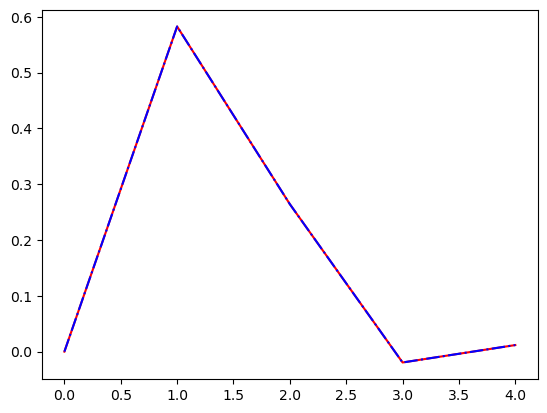

In [48]:
i,j = 3,4

plt.plot(T[:], X[:, i,j], color="red")
plt.plot(T[:], Y[:, i,j], ls="-.", color="blue")